# Evaluating Model Performance for Numerical Data

### Excercise: Comparing Model Performance
Load a dataset of choice, ameanible to linear regression analysis. You can use the data from the last workshop. Split the data into train - validation - and test. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_18048/2298807205.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/count_tree_data.csv')
print(df.columns)
df.drop('Unnamed: 0', axis=1, inplace=True)


Index(['Unnamed: 0', 'buurt_id', 'wijk_id', 'Naam_buurt', 'Code_buurt',
       'Cbscode_buurt', 'Geometrie_buurt', 'Naam_wijk', 'Code_wijk',
       'Cbscode_wijk', 'Geometrie_wijk', 'tree_count',
       'parked_cars_in_neighbourhood', 'species_count', 'total_area_ha',
       'land_area_ha', 'water_area_ha', 'built_up_area_ha',
       'total_green_area_ha', 'total_canopy_ha'],
      dtype='object')


In [3]:
# we have no categorical variable of use
'''
categorical_vars = []

# I want to store the dummies for particular variables so I can include/exclude 
# them in my regression
# indexed_dummy_columns = dict()

df_dummies = df.drop(categorical_vars, axis=1)

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    indexed_dummy_columns[category] = dummies.columns
    df_dummies = pd.concat([df_dummies, dummies], axis=1)
'''

'\ncategorical_vars = []\n\n# I want to store the dummies for particular variables so I can include/exclude \n# them in my regression\n# indexed_dummy_columns = dict()\n\ndf_dummies = df.drop(categorical_vars, axis=1)\n\nfor category in categorical_vars:\n    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)\n    dummies = dummies.astype(float)\n    indexed_dummy_columns[category] = dummies.columns\n    df_dummies = pd.concat([df_dummies, dummies], axis=1)\n'

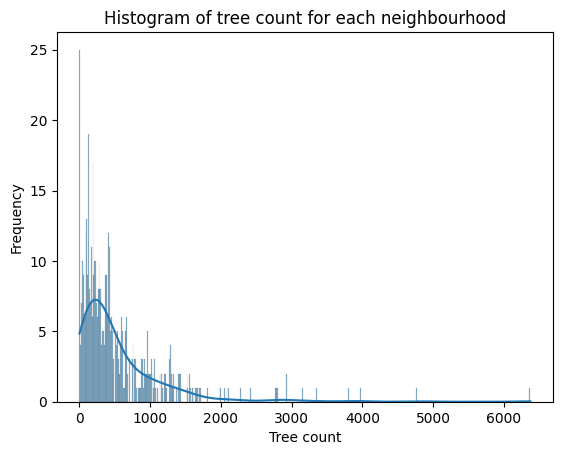

In [4]:
# tree count distribution
ax = sns.histplot(df['tree_count'], bins=518, kde=True).set(
    title="Histogram of tree count for each neighbourhood"
)
plt.xlabel('Tree count')
plt.ylabel('Frequency')
plt.show()


### 1a: Split your dataset into three parts, namely training, validation and test. 

In [5]:
def get_sets(df, y_variable, train_size=0.5, valid_size=0.25):
    shuffled_data = df.sample(frac=1, random_state=31415)

    total_size = len(shuffled_data.index)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * valid_size)

    train_set = shuffled_data.iloc[:train_size]
    validate_set = shuffled_data.iloc[train_size:(train_size + validation_size)]
    test_set = shuffled_data.iloc[(train_size + validation_size):]

    X_train = train_set.drop(y_variable, axis=1)
    y_train = train_set[y_variable]
    X_train_full = sm.add_constant(X_train)

    X_valid = validate_set.drop(y_variable, axis=1)
    y_valid = validate_set[y_variable]
    X_valid_full = sm.add_constant(X_valid)

    X_test = test_set.drop(y_variable, axis=1)
    y_test = test_set[y_variable]
    X_test_full = sm.add_constant(X_valid)

    return {
        'X_train_full': X_train_full, 
        'y_train': y_train, 
        'X_valid_full': X_valid_full, 
        'y_valid': y_valid, 
        'X_test_full': X_test_full, 
        'y_test': y_test
    }

In [6]:
df.columns

Index(['buurt_id', 'wijk_id', 'Naam_buurt', 'Code_buurt', 'Cbscode_buurt',
       'Geometrie_buurt', 'Naam_wijk', 'Code_wijk', 'Cbscode_wijk',
       'Geometrie_wijk', 'tree_count', 'parked_cars_in_neighbourhood',
       'species_count', 'total_area_ha', 'land_area_ha', 'water_area_ha',
       'built_up_area_ha', 'total_green_area_ha', 'total_canopy_ha'],
      dtype='object')

In [7]:
relevant_variables = ['tree_count', 'parked_cars_in_neighbourhood',
       'species_count', 'total_area_ha', 'land_area_ha', 'water_area_ha',
       'built_up_area_ha', 'total_green_area_ha', 'total_canopy_ha']

YX = df[relevant_variables]

y_var = 'tree_count'

split = get_sets(YX, y_var)

### 1b:  Compare 3 models on their performance on the validation set

Define 3 models, one `unsaturated` which uses only the intercept; one `fully saturated` which represents the most complex model you can generate, and one in between. Fit each model to the training data, and generate predictions for each model on the test_set. 

In [8]:
from statsmodels.api import GLM, Poisson

def fit_predict_evaluate(X_train, y_train, X_valid, y_valid, credibility_pct=95, n_sims = 10000):
    
    # Fit the model, poisson regression
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(X_valid)
    
    # Step 3: Calculate standard errors of the predictions on the validation set
    cov_matrix = model.cov_params()
    design_matrix = X_valid
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    # Since poisson distributions only have one parameter, we don't need
    # the variance
    # std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_counts = np.random.poisson(new_predictions_array,
                                         size=(len(new_predictions), n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_counts, axis=1)
    prediction_intervals = np.percentile(predicted_counts, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - y_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, monte_carlo_medians))
    correlation = np.corrcoef(y_valid, monte_carlo_medians)[0, 1]
    coverage = np.mean((y_valid >=  prediction_intervals[0,:]) & (y_valid <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [9]:
scores_homogeneous = fit_predict_evaluate(
    split['X_train_full'][['const']],
    split['y_train'],
    split['X_valid_full'][['const']],
    split['y_valid'],
    credibility_pct=95
)

In [10]:
YX.columns

Index(['tree_count', 'parked_cars_in_neighbourhood', 'species_count',
       'total_area_ha', 'land_area_ha', 'water_area_ha', 'built_up_area_ha',
       'total_green_area_ha', 'total_canopy_ha'],
      dtype='object')

In [11]:
# Let's see if how well we can perform with a simpler model.
# We'll look at species count, total area, total green area and total canopy area.
# This will model the count of trees based on biodiversity and simplified land data.
variables_of_interest = [
    'const',
    'species_count',
    'total_area_ha',
    'total_green_area_ha', 
    'total_canopy_ha'
]

scores_simple_model = fit_predict_evaluate(
    split['X_train_full'][variables_of_interest],
    split['y_train'],
    split['X_valid_full'][variables_of_interest],
    split['y_valid'],
    credibility_pct=95
)



In [12]:
scores_saturated_model = fit_predict_evaluate(
    split['X_train_full'],
    split['y_train'],
    split['X_valid_full'],
    split['y_valid'],
    credibility_pct=95
)

In [13]:
# generate a table with the scores 
scores = [
    {'name': 'Intercept Only', **scores_homogeneous},
    {'name': 'Simple model', **scores_simple_model},
    {'name': 'Saturated model', **scores_saturated_model},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

,Score Type,bias,rmse,correlation,coverage,predictions,prediction_intervals
0,Intercept Only,28.348837,584.268369,0.095420,0.031008,278 529.003861 367 529.003861 453 529...,"[[484.0, 483.0, 484.0, 484.0, 484.0, 484.0, 48..."
1,Simple model,41.279070,517.618555,0.567733,0.147287,278 509.181769 367 358.601373 453 423...,"[[466.0, 322.0, 383.0, 310.0, 309.0, 353.0, 27..."
2,Saturated model,27.341085,493.699317,0.621479,0.139535,278 1017.594782 367 232.214951 453 ...,"[[957.0, 202.0, 361.0, 219.0, 166.0, 367.0, 17..."


### 1c:  Comment on the scores

Can you identify a model to move forward with ? on what grounds ? 
What do the differences in performance over the different metrics tell you about each model's strengths and weaknesses ? 

1. The heterogenous models perform better than the homogeneous one, so there is certainly some relationship between some of the values I'm using to predict tree count, and tree count.

2. All models overestimate the number of trees by a small amount. The fact that we see this in the homogeneous model suggests that this is due to sampling (the test set simply has lower values than our train/validation sets). The simple model exaggerates this bias, suggesting that this is in fact due to the model itself.

3. The RMSE is very high when we consider that most neighbourhoods have around less than 1000 trees. All our models are very imprecise. We can expect our prediction to be off by a few hundred trees! This suggests that our predictor variables aren't very good at explaining the variance between similar neighbourhoods (or at least, similar according solely to the variables I'm using).

4. Correlation is pretty high in the heterogeneous models, so even if we can't explain the variance between neighbourhoods, we can say that our predictor variables can generally predict if the "range of plausible counts" should be higher or lower.

5. And finally we have poor coverage on all our models, which is probably due to our high variance.

### 1d: For your best performning model, estimate the generalisation error 

Generate point-estimates and a measure of uncertainty for each error metric. Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the empirical predictive posterior distribution. 

In [14]:
# Fit the model
# I will pick the "simple" model, it's almost as good as the saturated one with
# less complexity, thus it's more interpretable: "modelling tree count according
# to biodiversity and green area"

model = sm.GLM(
    split['y_train'], 
    split['X_train_full'][variables_of_interest],
    family=sm.families.Poisson(),
).fit()
    
# Step 2: Predict new values
new_predictions = model.predict(split['X_valid_full'][variables_of_interest])
    
# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = split['X_valid_full'][variables_of_interest]
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)
    
# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None] 
# poisson, don't need variance 
# std_errors_predictions_array = np.array(std_errors_predictions)[:, None] 

predicted_samples = np.random.poisson(new_predictions_array,
                                     size=(new_predictions.shape[0], 1000)) 

In [15]:
# Calculate metrics
bias_array = np.mean(predicted_samples - split['y_valid'].values[:,None], axis=0)
rmse_array = np.sqrt(np.mean((predicted_samples - split['y_valid'].values[:,None])**2, axis=0))
correlation_array = np.array([np.corrcoef(split['y_valid'].values[:,None], pred, rowvar=False)[0, 1] for pred in predicted_samples.T])
# Note: coverage doesn't have a distribution, because it is already a measure which is averaged over simulations. So it is omitted here - we know it from the table above. 
# Combine metrics into a single array where each metric is a column
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': correlation_array
}


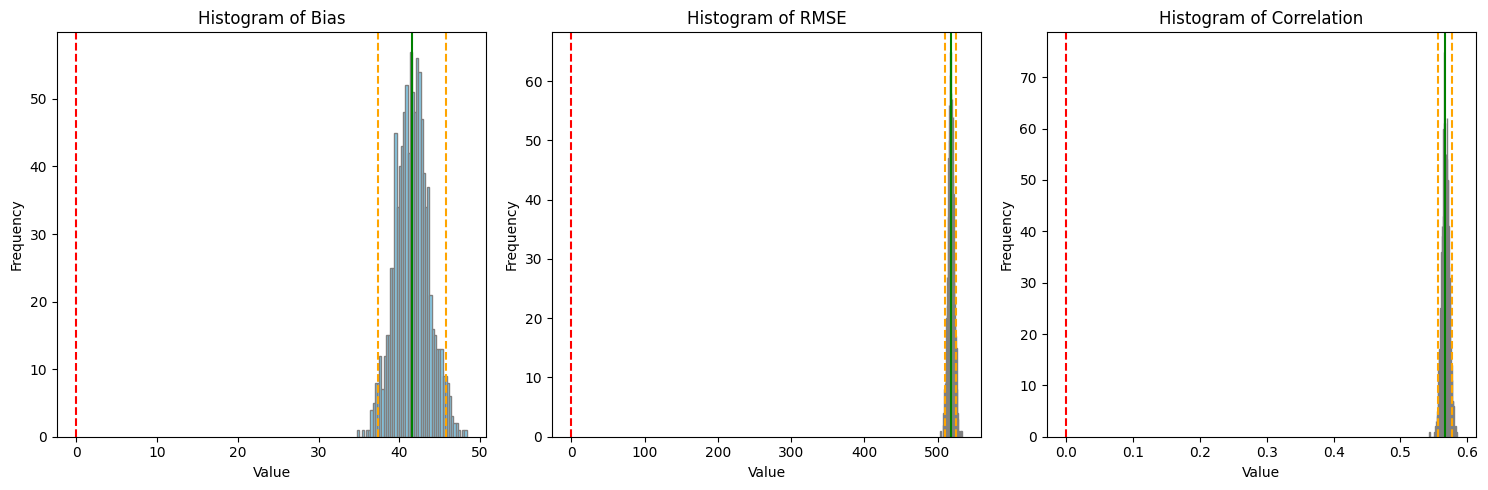

In [16]:
# plot the distributions of each error metric
import matplotlib.pyplot as plt

# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Define number of metrics to plot
n_metrics = len(metric_names)

# Adjust rows and columns calculation to avoid empty subplots
n_plots = n_metrics  # Total number of plots needed
n_rows = 1
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(metric_names):
    data = metrics[name]  # Access data directly from dictionary
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax = axes_flat[i]
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero line')  # Highlight 0 with a line
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Ensure plot encompasses 0 by adjusting xlim if necessary
    xlims = ax.get_xlim()
    ax.set_xlim(min(xlims[0], 0), max(xlims[1], 0))

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()